# Simulación de Montecarlo para esimar precio de opción Europea con Black & Scholes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime

## Funciones

In [65]:
# Funciones para crear variables normales: método de rechazo y antitéticas
def norm_dist_generator(lamb,n): #lamb debería ser 1
  norm=[]
  cont=0
  sw=1
  f_g=0
  u2=1
  while cont<n:
    u1=np.random.uniform(0,1)
    ex=-lamb*math.log(u1)
    f_g=math.e**-(((ex-1)**2)/2)
    u2=np.random.uniform(0,1)
    while u2>f_g:
      u1=np.random.uniform(0,1)
      ex=-lamb*math.log(u1)
      f_g=math.e**-(((ex-1)**2)/2)
      u2=np.random.uniform(0,1)
    if u2<=f_g:
      x=((-1)**cont)*ex
      norm.append(x)
      cont+=1
  return norm

def norm_dist_generator_anti_method(lamb,n): #lamb debería ser 1
  norm=[]
  cont=0
  sw=1
  f_g=0
  u2=1
  while cont<n:
    if cont%2==0:
      u1=np.random.uniform(0,1)
      ex=-lamb*math.log(u1)
      f_g=math.e**-(((ex-1)**2)/2)
      u2=np.random.uniform(0,1)
      while u2>f_g:
        u1=np.random.uniform(0,1)
        ex=-lamb*math.log(u1)
        f_g=math.e**-(((ex-1)**2)/2)
        u2=np.random.uniform(0,1)
      if u2<=f_g:
        x=((-1)**cont)*ex
        norm.append(x)
        cont+=1
    else:
      u1=1-np.random.uniform(0,1)
      ex=-lamb*math.log(u1)
      f_g=math.e**-(((ex-1)**2)/2)
      u2=1-np.random.uniform(0,1)
      while u2>f_g:
        u1=1-np.random.uniform(0,1)
        ex=-lamb*math.log(u1)
        f_g=math.e**-(((ex-1)**2)/2)
        u2=1-np.random.uniform(0,1)
      if u2<=f_g:
        x=((-1)**cont)*ex
        norm.append(x)
        cont+=1
  return norm

## Limpieza de Datos

In [2]:
df = pd.read_excel("Datos_banxico.xlsx")
df.head(15)
# df1 = pd.read_excel("Datos_banxico(1).xlsx")
# df1

/Users/macuser/opt/anaconda3/envs/TEC/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Banco de México,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tasas y precios de referencia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tasas de interés representativas,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fecha de consulta: 10/10/2022 09:44:25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Título,TIIE a 182 días,"TIIE de Fondeo a Un Día Hábil Bancario, Median...","Tasa de fondeo bancario, Mediana ponderada por...","Tasa de fondeo gubernamental, Mediana ponderad...","TIIE a 28 días, Tasa de interés en por ciento ...",Tasas de interés interbancarias Por ciento anu...,Tasa objetivo
9,Tipo de información,Niveles,Niveles,Niveles,Niveles,Niveles,Niveles,Niveles


In [3]:
new_df = df[['Banco de México','Unnamed: 5']]
new_df = new_df.drop([0,1,2,3,4,5,6,7,8,9,10])
new_df.columns = ['Fecha','Tasa']
new_df.head()

,Fecha,Tasa
11,2008-01-02 00:00:00,7.93
12,2008-01-03 00:00:00,7.9362
13,2008-01-04 00:00:00,7.9312
14,2008-01-07 00:00:00,7.9275
15,2008-01-08 00:00:00,7.9262


In [4]:
new_df.reset_index(drop=True, inplace=True)
new_df.head()

,Fecha,Tasa
0,2008-01-02 00:00:00,7.93
1,2008-01-03 00:00:00,7.9362
2,2008-01-04 00:00:00,7.9312
3,2008-01-07 00:00:00,7.9275
4,2008-01-08 00:00:00,7.9262


In [5]:
new_df.count()

Fecha    5299
Tasa     5299
dtype: int64

In [6]:
new_df.loc[new_df['Tasa']=='N/E'].count()


Fecha    1581
Tasa     1581
dtype: int64

In [7]:
clean_df = new_df[new_df.Tasa != 'N/E']
clean_df.count()

Fecha    3718
Tasa     3718
dtype: int64

In [8]:
clean_df = clean_df.tail(253)
clean_df.count()

Fecha    253
Tasa     253
dtype: int64

## Estimación de media y desv.std y calcular Incrementos

In [9]:
h = 1/253

In [10]:
clean_df.reset_index(drop=True, inplace=True)

In [11]:
clean_df['Tasa'].head()

0    4.9862
1    4.9825
2    4.9857
3    4.9806
4    4.9855
Name: Tasa, dtype: object

In [12]:
clean_df['Incrementos'] = 0
for i in range(len(clean_df['Tasa'])):
    if i > 0:
        clean_df['Incrementos'][i] = (np.log(clean_df['Tasa'][i]) - np.log(clean_df['Tasa'][i-1]))

clean_df

/var/folders/nw/lv4rq7hs6lx_2ggkd6czwz2r0000gn/T/ipykernel_5724/2009250070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Incrementos'][i] = (np.log(clean_df['Tasa'][i]) - np.log(clean_df['Tasa'][i-1]))


,Fecha,Tasa,Incrementos
0,2021-10-12 00:00:00,4.9862,0.000000
1,2021-10-13 00:00:00,4.9825,-0.000742
2,2021-10-14 00:00:00,4.9857,0.000642
3,2021-10-15 00:00:00,4.9806,-0.001023
4,2021-10-18 00:00:00,4.9855,0.000983
...,...,...,...
248,2022-10-04 00:00:00,9.5366,0.000168
249,2022-10-05 00:00:00,9.5453,0.000912
250,2022-10-06 00:00:00,9.5515,0.000649
251,2022-10-07 00:00:00,9.5451,-0.000670


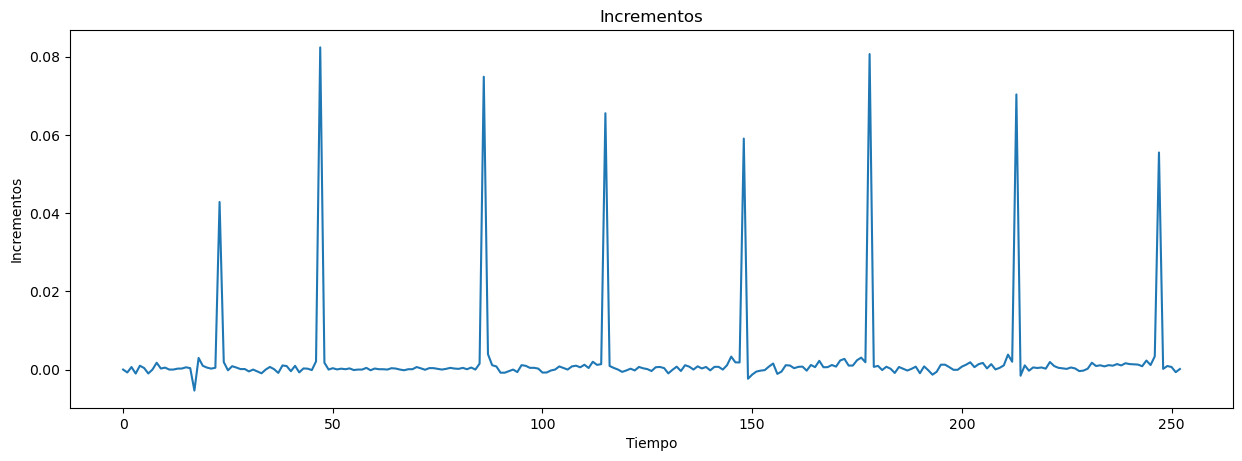

In [13]:
# Grafica de los incrementos
plt.figure(figsize=(15,5), dpi=100, facecolor='w', edgecolor='k', frameon=True, clear=True)
plt.plot(clean_df['Incrementos'])
plt.title('Incrementos')
plt.xlabel('Tiempo')
plt.ylabel('Incrementos')
plt.show()

In [14]:
media_x = clean_df['Incrementos'].mean()
varianza_x = clean_df['Incrementos'].var()

print(media_x, varianza_x)

0.002567195646482264 0.00013965534149767837


In [15]:
mu = (media_x/h)+(varianza_x/(2*h))
sigma = (math.sqrt(varianza_x)/math.sqrt(h))

print(mu, sigma)

0.6671668992594691 0.1879702141269


## Montecarlo Simulation

In [54]:
plt.figure(figsize=(15, 5), dpi=100, facecolor='w', edgecolor='k')
t = list(range(0, 253))

res_exp = []
graph=[]
for i in range(10000):
    random_vars = np.array(norm_dist_generator(1,253))
    s = clean_df['Tasa'][0]
    new_list = []

    for j in random_vars:
        x_i = (mu*h) - (((sigma**2)/2)*h) + (sigma*math.sqrt(h)*j)
        new_list.append(x_i)

    for x in range(len(new_list)):
        values_sum = sum(new_list[0:x+1])
        exp_lista = s * math.exp(values_sum)
        graph.append(exp_lista)
    res_exp.append(exp_lista)

S = np.array(res_exp).mean()
print(S)


# plt.show()


9.703670556170918


<Figure size 1500x500 with 0 Axes>

### Mc Visualization

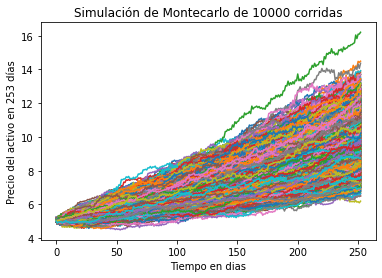

In [55]:
for i in range(1,10001):
    plt.xlabel('Tiempo en dias')
    plt.ylabel('Precio del activo en 253 días')
    plt.title("Simulación de Montecarlo de 10000 corridas")
    plt.plot(t,graph[253*(i-1):253*i])

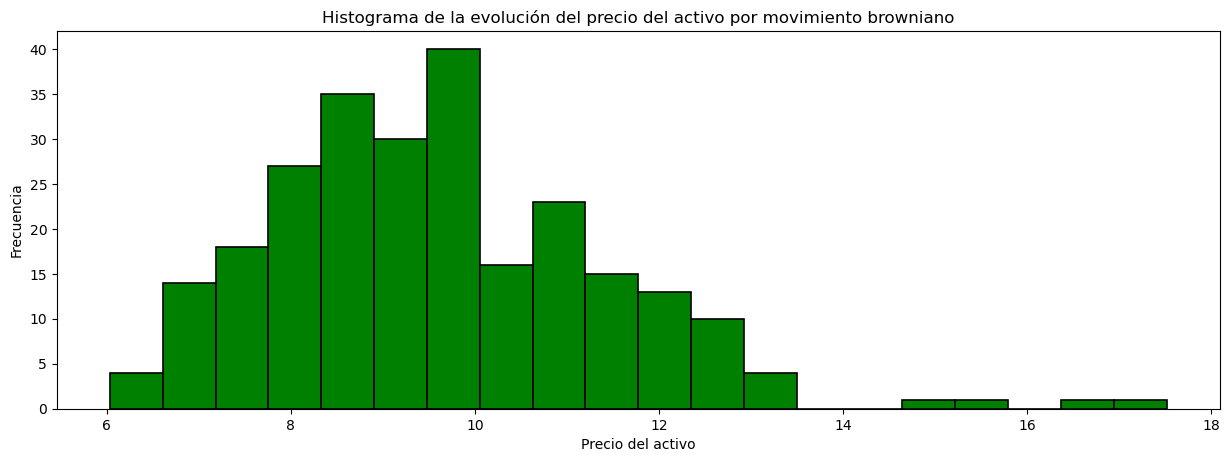

In [ ]:
plt.figure(figsize=(15,5), dpi=100, facecolor='w', edgecolor='k')
plt.hist(res_exp, bins=20, color = 'green', edgecolor = 'black', linewidth = 1.2)
plt.title('Histograma de la evolución del precio del activo por movimiento browniano')
plt.xlabel('Precio del activo')
plt.ylabel('Frecuencia')
plt.show()


## Black and Scholes

In [56]:
K = 105
Libor = int(clean_df['Tasa'][252]*10)
libor = Libor/100
T = 253
t = 0
tao = T-t
r = np.log(1+(libor/100))
d_1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
d_2 = d_1 - sigma*math.sqrt(tao)
print(d_1, d_2,r)

1.4985030979105682 -1.4913461882449892 0.009455158770755197


In [57]:
from scipy.stats import norm
N = norm.cdf
C = (S)*N(d_1) - K*math.exp(-r*(tao))*(N(d_2))
print(C)

8.40130560883845
